<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_latent_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 1: Python Preliminaries**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 7 Material

* Part 7.1: Introduction to GANs for Image and Data Generation [[Video]](https://www.youtube.com/watch?v=hZw-AjbdN5k&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_1_gan_intro.ipynb)
* Part 7.2: Train StyleGAN3 with your Own Images [[Video]](https://www.youtube.com/watch?v=R546LYsQk5M&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_train_gan.ipynb)
* **Part 7.3: Exploring the StyleGAN Latent Vector** [[Video]](https://www.youtube.com/watch?v=goQzp8QSb2s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_latent_vector.ipynb)
* Part 7.4: GANs to Enhance Old Photographs Deoldify [[Video]](https://www.youtube.com/watch?v=0OTd5GlHRx4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_4_deoldify.ipynb)
* Part 7.5: GANs for Tabular Synthetic Data Generation [[Video]](https://www.youtube.com/watch?v=yujdA46HKwA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_5_tabular_synthetic.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


# Part 7.3: Exploring the StyleGAN Latent Vector

StyleGAN seeds, such as 3000, are only random number seeds used to generate much longer 512-length latent vectors, which create the GAN image.  If you make a small change to the seed, for example, change 3000 to 3001, StyleGAN will create an entirely different picture.  However, if you make a small change to a few latent vector values, the image will only change slightly.  In this part, we will see how we can fine-tune the latent vector to control, to some degree, the resulting GAN image appearance.

## Installing Needed Software

We begin by installing StyleGAN.

In [2]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 193 (delta 90), reused 153 (delta 86), pack-reused 0
Receiving objects: 100% (193/193), 4.17 MiB | 5.24 MiB/s, done.
Resolving deltas: 100% (90/90), done.
     |████████████████████████████████| 108 kB 13.5 MB/s 


We will use the same functions introduced in the previous part to generate GAN seeds and images.

In [3]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
        nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class'\
                   'when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running '\
            'on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, 
                   noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, 
          noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128)\
    .clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

Next, we load the NVIDIA FFHQ (faces) GAN.  We could use any StyleGAN pretrained GAN network here.

In [4]:
# HIDE CODE

URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/"\
  "stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print('Loading networks from "%s"...' % URL)
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema']\
      .requires_grad_(False).to(device) 

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


## Generate and View GANS from Seeds

We will begin by generating a few seeds to evaluate potential starting points for our fine-tuning. Try out different seeds ranges until you have a seed that looks close to what you wish to fine-tune.

Seed 4020
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


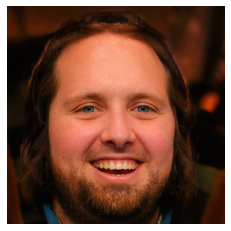

Seed 4021


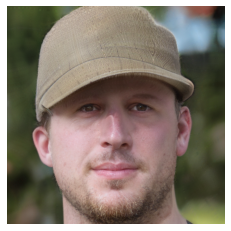

Seed 4022


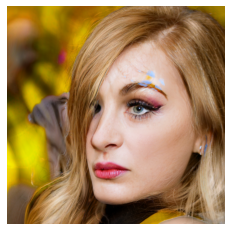

In [5]:
# HIDE OUTPUT 1
# Choose your own starting and ending seed.
SEED_FROM = 4020
SEED_TO = 4023

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

## Fine-tune an Image

If you find a seed you like, you can fine-tune it by directly adjusting the latent vector.  First, choose the seed to fine-tune.

In [6]:
START_SEED = 4022

current = seed2vec(G, START_SEED)

Next, generate and display the current vector. You will return to this point for each iteration of the finetuning.

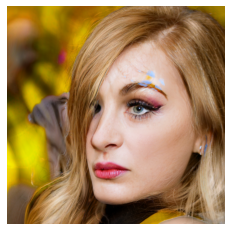

In [7]:
img = generate_image(device, G, current)

SCALE = 0.5
display_image(img)

Choose an explore size; this is the number of different potential images chosen by moving in 10 different directions.  Run this code once and then again anytime you wish to change the ten directions you are exploring.  You might change the ten directions if you are no longer seeing improvements.

In [8]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Each image displayed from running this code shows a potential direction that we can move in the latent vector.  Choose one image that you like and change MOVE_DIRECTION to indicate this decision.  Once you rerun the code, the code will give you a new set of potential directions.  Continue this process until you have a latent vector that you like.

Direction 0


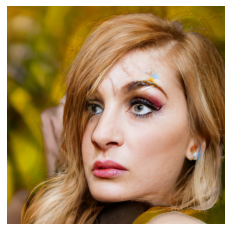

Direction 1


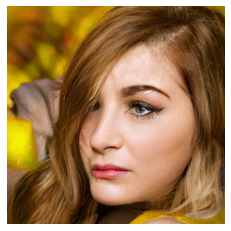

Direction 2


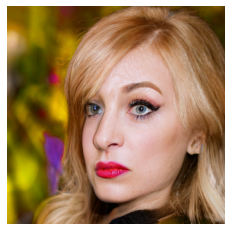

Direction 3


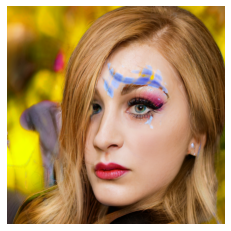

Direction 4


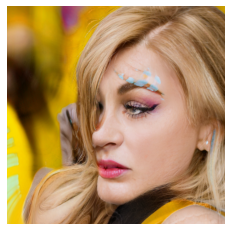

Direction 5


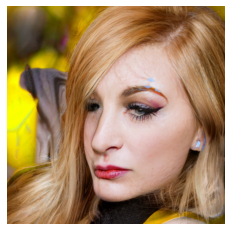

Direction 6


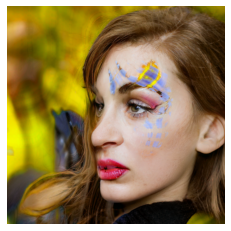

Direction 7


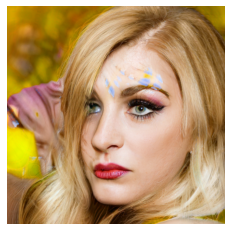

Direction 8


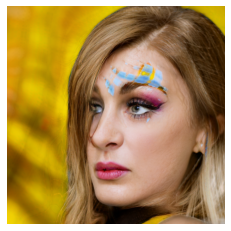

Direction 9


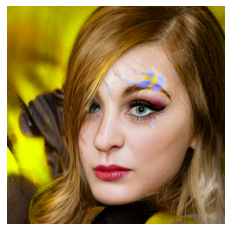

Direction 10


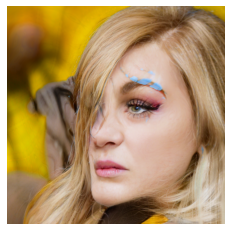

Direction 11


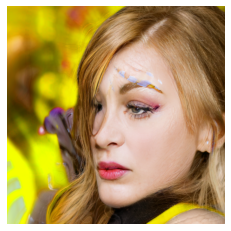

Direction 12


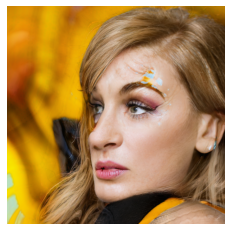

Direction 13


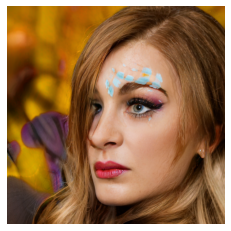

Direction 14


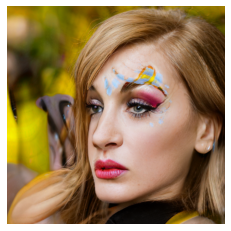

Direction 15


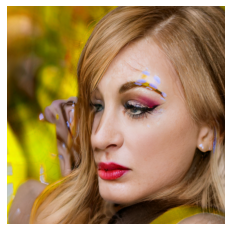

Direction 16


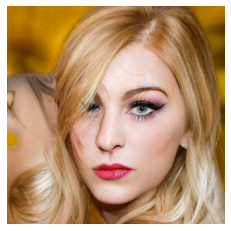

Direction 17


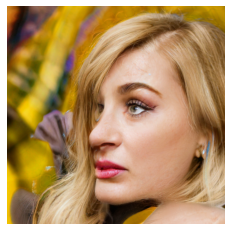

Direction 18


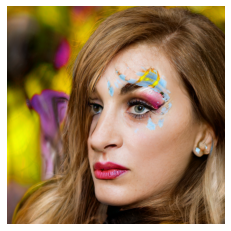

Direction 19


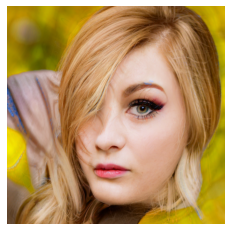

Direction 20


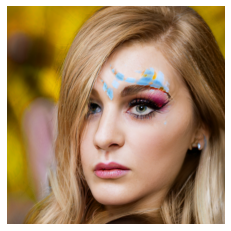

Direction 21


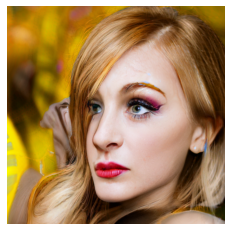

Direction 22


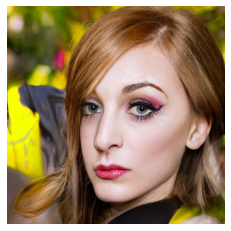

Direction 23


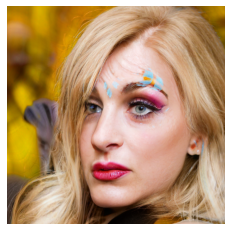

Direction 24


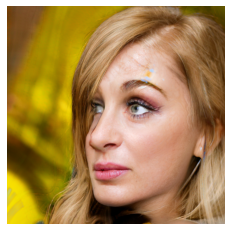

In [9]:
# HIDE OUTPUT 1
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  z = current + mv
  img = generate_image(device, G, z)
  display_image(img)